# MSc Data Science lab: Semi supervised deep learning via entropy minimisation

We're going to use the entropy minimisation technique of [Grandvalet and Bengio (2004)](https://papers.nips.cc/paper/2740-semi-supervised-learning-by-entropy-minimization.pdf) to learn a MNIST classifier using only 1000 labels. 

# Loading useful stuff

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and removing some labels

In [0]:
(xtrain, ytrain), (xtest,  ytest) = tf.keras.datasets.mnist.load_data()
xtrain = (xtrain/255.).reshape([-1,28,28,1])
xtest = (xtest/255.).reshape([-1,28,28,1])
ytrain = tf.cast(ytrain, tf.int64)
ytest =tf.cast(ytest, tf.int64)

11493376/11490434 [==============================] - 0s 0us/step


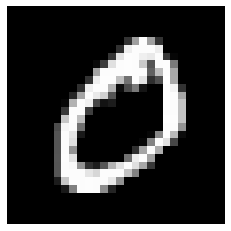

In [0]:
plt.imshow(xtrain[1, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

We only keep the labels of the first 1000 digits.

**Question:** What do you think of this choice?

In [0]:
train_dataset_labels = tf.data.Dataset.from_tensor_slices((xtrain[:1000,],ytrain[:1000])).shuffle(60000).batch(32) # TF creates the batches for us
train_dataset_nolabels = tf.data.Dataset.from_tensor_slices((xtrain[1000:,])).shuffle(60000).batch(32) # TF creates the batches for us

## Classification using only the labelled data

Let us first build a small neural net to classify MNIST. The model is:
$$ p (y | \mathbf{x} ) = \text{Cat} (y |\text{Convnet}(\mathbf{x})),$$
and the architecture of the convnet is similar to the famous LeNet.

In [0]:
classifier = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28,28,1,]),
  tfkl.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation="relu", input_shape=(28,28,1), padding="same",kernel_initializer="he_normal"),
  tfkl.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid"),
  tfkl.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="valid",kernel_initializer="he_normal"),
  tfkl.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
  tfkl.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="valid",kernel_initializer="he_normal"),
  tfkl.Flatten(),
  tfkl.Dense(84, activation="relu",kernel_initializer="he_normal"),
  tfkl.Dense(10, activation="softmax")
])

To train the classifier, we define a function that performs a gradient descent step. First, we choose the flavour of SGD that we want (in this case, Adam).

In [0]:
optimizer = tfk.optimizers.Adam(learning_rate=0.0005)

We can now define the gradient step:

In [0]:
@tf.function
def train_step(data, labels):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    preds = classifier(data)
    p_ygivenx_model = tfd.Categorical(probs = preds+0.0001) # One could also use logits rather than probs and remove the softmax layer...
    logp_ygivenx = p_ygivenx_model.log_prob(labels)
    loss = -tf.reduce_mean(logp_ygivenx)  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, classifier.trainable_variables)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, classifier.trainable_variables))  # Adam iteration

To evaluate the quality of our model, we will write a function that computes both accuracy and log_likelihood. We don't care about gradients here bacause it's only for evaluation (not for training).

In [0]:
@tf.function
def evaluate(data, labels):
  preds = classifier(data)
  p_ygivenx_model = tfd.Categorical(probs = preds+0.0001)
  logp_ygivenx = p_ygivenx_model.log_prob(labels)
  log_likelihood = tf.reduce_mean(logp_ygivenx)
  y_pred = tf.argmax(preds,1)
  acc = tf.reduce_mean(tf.cast(y_pred == labels,tf.float32))
  return acc, log_likelihood

Now we train the model using only the labelled data.

In [0]:
EPOCHS = 1002

acc = np.zeros(EPOCHS+1)
ll = np.zeros(EPOCHS+1)

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset_labels:
    train_step(images, labels) # Adam iteration
  acc_train, log_likelihood_train = evaluate(xtrain[:1000,],ytrain[:1000])
  acc_test, log_likelihood_test = evaluate(xtest,ytest)
  acc[epoch] = acc_test.numpy()
  ll[epoch] = log_likelihood_test.numpy()
  if (epoch % 200 == 1): 
    print('Epoch  %g' %epoch)
    print('Train accuracy  %g' %acc_train.numpy())
    print('Test accuracy  %g' %acc_test.numpy())
    print('Train log-likelihood  %g' %log_likelihood_train.numpy())
    print('Test log-likelihood  %g' %log_likelihood_test.numpy())
    print('-----------')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch  1
Train accuracy  0.835
Test accuracy  0.798
Train log-likelihood  -0.55119
Test log-likelihood  -0.658724
-----------
Epoch  201
Train accuracy  1
Test accuracy  0.9375
Train log-likelihood  -0.000902651
Test log-likelihood  -0.338861
-----------
Epoch  401
Train accuracy  1
Test accuracy  0.9391
Train log-likelihood  -0.00089971
Test log-likelihood  -0.366509
-----------
Epoch  601
Train accuracy  1
Test accuracy  0.9393
Train log-likelihood  -0.000899652
Test log-likelihood  -0.389106
--------

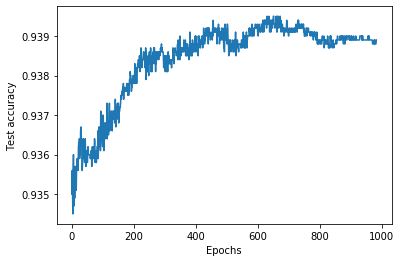

In [0]:
plt.plot(acc[20:])
plt.ylabel('Test accuracy')
plt.xlabel('Epochs')
plt.show()

**Question:** Implement entropy minimisation to leverage both labelled and unlabelled digits.